# Importing Libraries


In [1]:
# Basic data and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')


# Loading the Dataset

In [2]:
# Load dataset
df = pd.read_excel("C:/Users/HP N4000/Documents/DataScience/Customer segmentation/Online_Retail.xlsx")

# Preview the data
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Initial dataset cleaning 

In [3]:
# Drop rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])
df.drop(columns=['StockCode', 'InvoiceNo', 'Description'], inplace=True)


# Drop duplicates
df = df.drop_duplicates()

# Confirm the cleaning
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 255290 entries, 0 to 541908
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Quantity     255290 non-null  int64         
 1   InvoiceDate  255290 non-null  datetime64[ns]
 2   UnitPrice    255290 non-null  float64       
 3   CustomerID   255290 non-null  float64       
 4   Country      255290 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 11.7+ MB


### Convert data types 

In [4]:
# Ensure 'InvoiceDate' is datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Make sure 'CustomerID' is a string
df['CustomerID'] = df['CustomerID'].astype(str)

# Check the updated types
df.dtypes


Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
dtype: object

### Add a Total Price column 

In [5]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df.head()


,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
5,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,15.30
6,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,25.50


# RFM Feature Engineering

#####  1) Define a snapshot date

In [6]:
# Snapshot date is one day after the last invoice
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
snapshot_date


Timestamp('2011-12-10 12:50:00')

##### 2)Group by Customer and calculate R, F, M

In [7]:
# Group by CustomerID to calculate RFM metrics
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Quantity': 'count',                                      # Frequency (number of purchases)
    'TotalPrice': 'sum'                                       # Monetary value
})

# Rename the columns
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'Quantity': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

# Preview the RFM table
rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,2,0.00
12347.0,2,116,3125.98
12348.0,75,20,1399.80
12349.0,19,45,1209.49
12350.0,310,9,174.20


##### 3) Check for outliers (optional but useful)

In [8]:
rfm.describe()


,Recency,Frequency,Monetary
count,4372.000000,4372.000000,4372.000000
mean,92.047118,58.392040,1386.254628
std,100.765435,133.086282,6068.741197
min,1.000000,1.000000,-4287.630000
25%,17.000000,12.000000,209.745000
50%,50.000000,28.000000,476.520000
75%,143.000000,65.000000,1126.382500
max,374.000000,4384.000000,201642.830000


###### 4) Normalise RFM table 
K-Means uses Euclidean distance, so we need to scale all values to the same range — otherwise, large numbers (like Monetary) dominate the clustering.

We’ll use MinMaxScaler to scale everything between 0 and 1.

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the RFM values
rfm_scaled = scaler.fit_transform(rfm)

# Convert back to DataFrame
rfm_scaled = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'], index=rfm.index)

# Preview
rfm_scaled.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,0.871314,0.000228,0.020821
12347.0,0.002681,0.026238,0.036001
12348.0,0.198391,0.004335,0.027618
12349.0,0.048257,0.010039,0.026694
12350.0,0.828418,0.001825,0.021667


##### 5) Clustering with KMeans

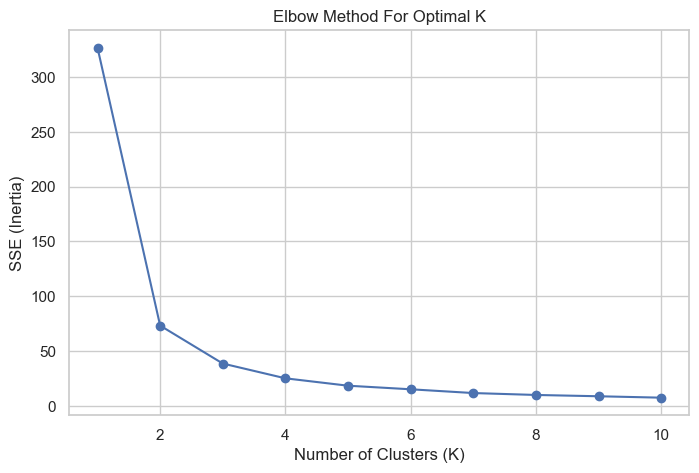

In [10]:
#Elbow method
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Try K from 1 to 10
sse = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)  # inertia = sum of squared distances

# Plot the elbow
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method For Optimal K')
plt.grid(True)
plt.show()


In [11]:
# silhouette method
from sklearn.metrics import silhouette_score

# Try K from 2 to 10 (can't use silhouette for K=1)
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    print(f"K={k}, Silhouette Score={score:.4f}")


K=2, Silhouette Score=0.7268
K=3, Silhouette Score=0.6568
K=4, Silhouette Score=0.5759
K=5, Silhouette Score=0.5701
K=6, Silhouette Score=0.5345
K=7, Silhouette Score=0.5472
K=8, Silhouette Score=0.5332
K=9, Silhouette Score=0.5330
K=10, Silhouette Score=0.5340


This means that: 
The higher the silhouette score, the better the separation between clusters.

K = 2 has the highest score (0.7268), which means it gives the most distinct, well-separated clusters.



##### 6) Final KMeans Model (Choose your best K)

In [12]:
# Final KMeans model with K=2
kmeans = KMeans(n_clusters=2, random_state=42)
rfm_scaled['Cluster'] = kmeans.fit_predict(rfm_scaled)
rfm['Cluster'] = rfm_scaled['Cluster']  # join to original RFM

# Preview the final clusters
rfm.groupby('Cluster').mean()


,Recency,Frequency,Monetary
Cluster,,,
0,40.575813,71.400486,1726.112028
1,248.746531,18.789084,351.591629


###### 7) Visualise clusters 

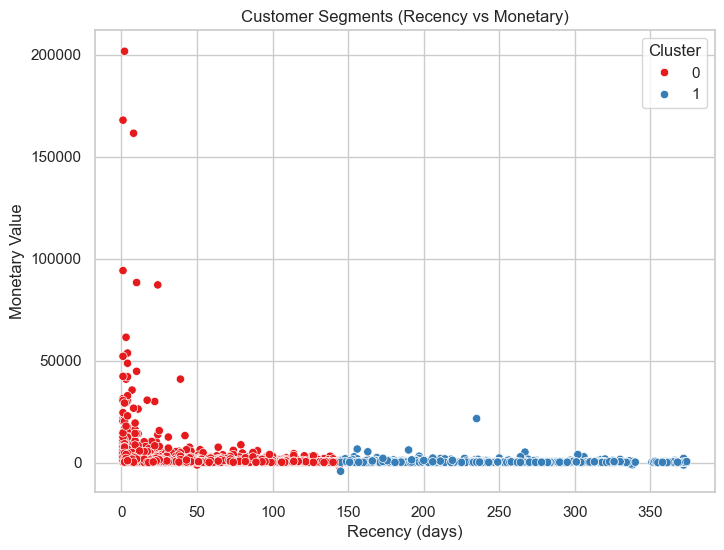

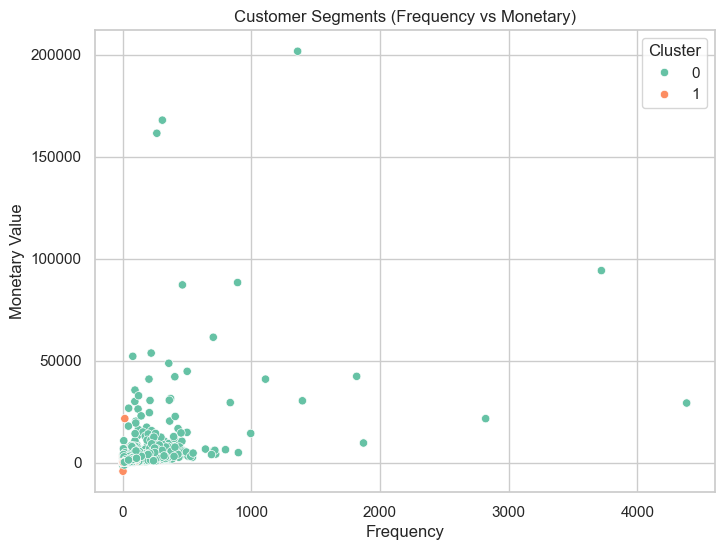

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# 2D Scatter: Recency vs Monetary
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='Set1')
plt.title('Customer Segments (Recency vs Monetary)')
plt.xlabel('Recency (days)')
plt.ylabel('Monetary Value')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# 2D Scatter: Frequency vs Monetary
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Cluster', palette='Set2')
plt.title('Customer Segments (Frequency vs Monetary)')
plt.xlabel('Frequency')
plt.ylabel('Monetary Value')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


##### 8)Let’s try Agglomerative Clustering for comparison

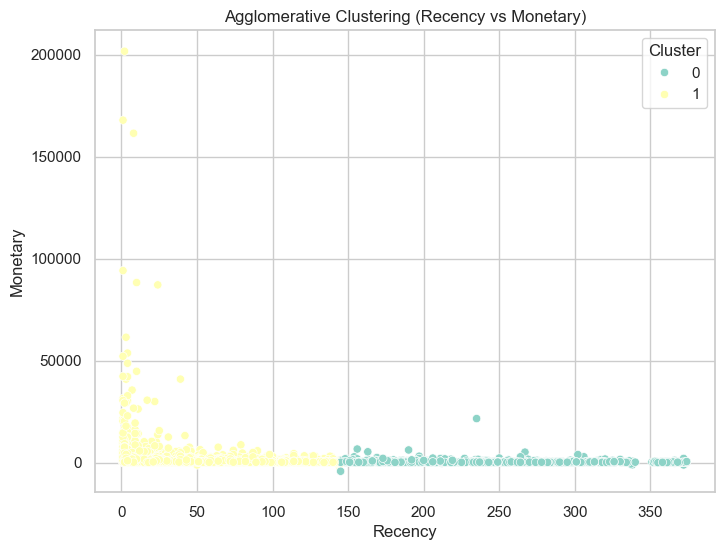

In [14]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=2)
rfm_scaled['Agg_Cluster'] = agg.fit_predict(rfm_scaled)
rfm['Agg_Cluster'] = rfm_scaled['Agg_Cluster']

# Visualize Agglomerative Clustering
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Agg_Cluster', palette='Set3')
plt.title('Agglomerative Clustering (Recency vs Monetary)')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


###### 9) Silhouette Score Comparison

In [15]:
from sklearn.metrics import silhouette_score

kmeans_score = silhouette_score(rfm_scaled.drop(['Agg_Cluster'], axis=1), rfm_scaled['Cluster'])
agg_score = silhouette_score(rfm_scaled.drop(['Agg_Cluster'], axis=1), rfm_scaled['Agg_Cluster'])

print(f"KMeans Silhouette Score: {kmeans_score:.4f}")
print(f"Agglomerative Clustering Silhouette Score: {agg_score:.4f}")


KMeans Silhouette Score: 0.8801
Agglomerative Clustering Silhouette Score: 0.8801


# MLFLOW (Machine learning Operations)

In [16]:
import mlflow
mlflow.__version__


'3.1.0'

##### 1) Set Up MLflow Run

In [17]:
import os
mlflow.get_tracking_uri()


'file:///C:/Users/HP%20N4000/Documents/DataScience/Customer%20segmentation/mlruns'

In [18]:
import mlflow

mlflow.set_tracking_uri("file:///C:/Users/HP N4000/Documents/DataScience/Customer segmentation/mlruns")


In [19]:
import mlflow
import mlflow.sklearn
from sklearn.cluster import KMeans

mlflow.set_tracking_uri("file:///C:/Users/HP N4000/Documents/DataScience/Customer segmentation/mlruns")

with mlflow.start_run(run_name="kmeans_test_run"):
    model = KMeans(n_clusters=3, random_state=42)
    model.fit(rfm_scaled)

    mlflow.log_param("n_clusters", 3)
    mlflow.log_metric("inertia", model.inertia_)
    mlflow.sklearn.log_model(model, "kmeans_model")


2025/06/30 23:28:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/30 23:32:52 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\HPN400~1\AppData\Local\Temp\tmpn4c7hvg7\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/06/30 23:32:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### Visualizing RFM Clusters (2D scatter plots)

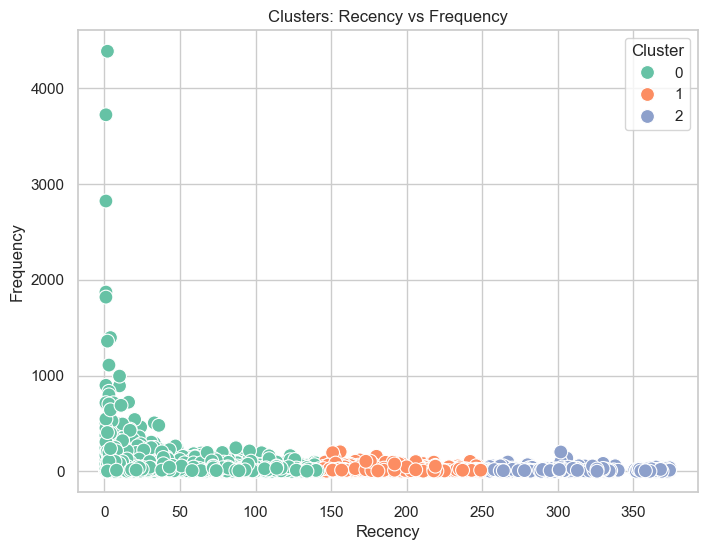

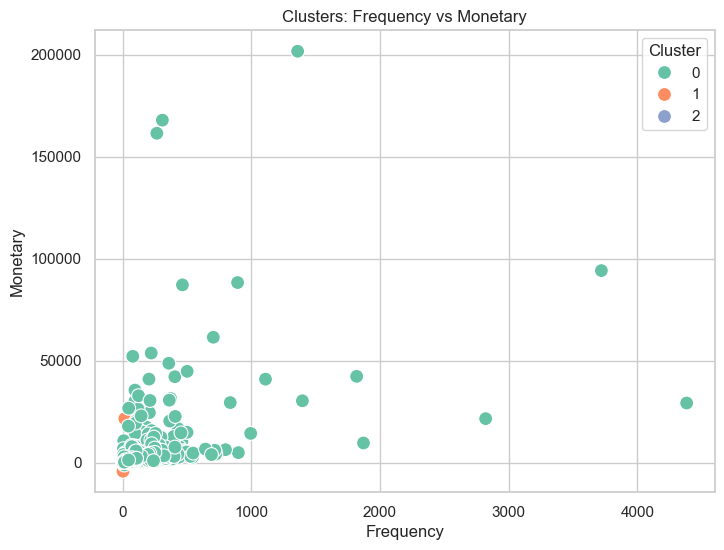

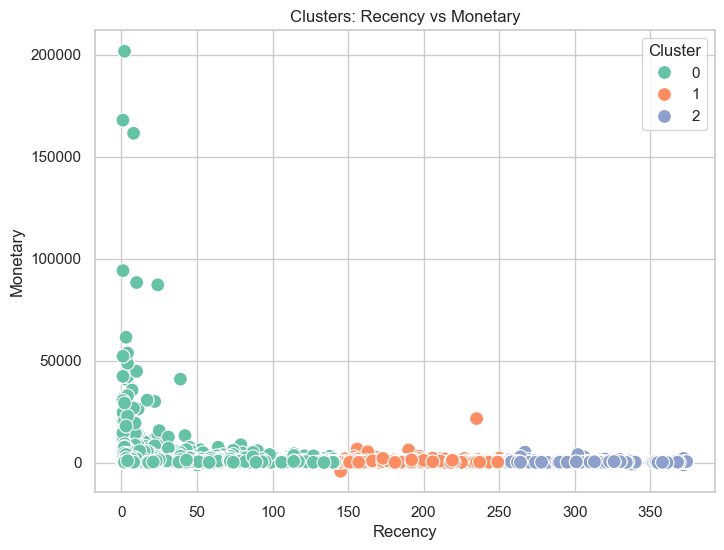

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Create a copy for visualization
rfm_vis = rfm.copy()
rfm_vis['Cluster'] = model.predict(rfm_scaled)

# Set up Seaborn style
sns.set(style="whitegrid")

# Plot 1: Recency vs Frequency
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm_vis, x='Recency', y='Frequency', hue='Cluster', palette='Set2', s=100)
plt.title('Clusters: Recency vs Frequency')
plt.show()

# Plot 2: Frequency vs Monetary
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm_vis, x='Frequency', y='Monetary', hue='Cluster', palette='Set2', s=100)
plt.title('Clusters: Frequency vs Monetary')
plt.show()

# Plot 3: Recency vs Monetary
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm_vis, x='Recency', y='Monetary', hue='Cluster', palette='Set2', s=100)
plt.title('Clusters: Recency vs Monetary')
plt.show()


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add cluster labels (if not already added)
rfm['Cluster'] = model.predict(rfm_scaled)

# Set Seaborn style
sns.set(style="whitegrid")

# Plot 1: Recency vs Frequency
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Cluster', palette='Set2', s=100)
plt.title('Clusters: Recency vs Frequency')
plt.savefig("recency_vs_frequency.png")
plt.close()

# Plot 2: Frequency vs Monetary
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Cluster', palette='Set2', s=100)
plt.title('Clusters: Frequency vs Monetary')
plt.savefig("frequency_vs_monetary.png")
plt.close()

# Plot 3: Recency vs Monetary
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='Set2', s=100)
plt.title('Clusters: Recency vs Monetary')
plt.savefig("recency_vs_monetary.png")
plt.close()


#### Setting Up Github

In [22]:
with open('.gitignore', 'w') as f:
    f.write("""__pycache__/
.ipynb_checkpoints/
mlruns/
*.png
*.csv
.env
""")


 ### DBSCAN Clustering Integration

In [23]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

with mlflow.start_run(run_name="DBSCAN") as run:
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    labels = dbscan.fit_predict(rfm_scaled)

    # Filter out noise (-1) before computing silhouette
    core_samples_mask = labels != -1
    if len(set(labels)) > 1 and len(set(labels)) < len(rfm_scaled):  # basic check
        sil_score = silhouette_score(rfm_scaled[core_samples_mask], labels[core_samples_mask])
        mlflow.log_metric("silhouette_score", sil_score)
    else:
        mlflow.log_param("error", "Too few clusters or all noise")

    mlflow.log_param("eps", 0.5)
    mlflow.log_param("min_samples", 5)


### Agglomerative Clustering Integration

In [24]:
from sklearn.cluster import AgglomerativeClustering

with mlflow.start_run(run_name="Agglomerative") as run:
    agglo = AgglomerativeClustering(n_clusters=3)
    labels = agglo.fit_predict(rfm_scaled)

    sil_score = silhouette_score(rfm_scaled, labels)
    mlflow.log_param("n_clusters", 3)
    mlflow.log_metric("silhouette_score", sil_score)


###### Cluster Comparison Plots

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_clusters(data, labels, title, filename):
    import numpy as np
    data_np = data.to_numpy() if hasattr(data, 'to_numpy') else data  # Ensure it's a NumPy array
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=data_np[:, 0], y=data_np[:, 1], hue=labels, palette='Set2')
    plt.title(title)
    plt.savefig(filename)
    plt.close()
    
plot_clusters(rfm_scaled, dbscan.labels_, "DBSCAN Clustering", "plots/dbscan_clusters.png")
plot_clusters(rfm_scaled, agglo.labels_, "Agglomerative Clustering", "plots/agglo_clusters.png")
